## March Madness Logistic Regression

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
mm_data = pd.read_csv('NCAA_Tourney_2002_2018.csv')

In [4]:
mm_2019 = pd.read_csv('NCAA_Tourney_2019.csv')

In [5]:
mm_data.columns

Index(['team1_id', 'team1_score', 'team2_id', 'team2_score', 'result', 'WLoc',
       'num_ot', 'team1_position', 'team2_position', 'team1_seed',
       ...
       'diff_arate', 'diff_opparate', 'diff_stlrate', 'diff_oppstlrate',
       'diff_tempo', 'diff_adjtempo', 'diff_oe', 'diff_adjoe', 'diff_de',
       'diff_adjde'],
      dtype='object', length=139)

In [6]:
mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)
mm_2019['dist1'] = mm_2019.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_2019['dist2'] = mm_2019.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [7]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']
mm_2019['diff_dist'] = mm_2019['dist1'] - mm_2019['dist2']

## Pythag College Basketball
E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

In [8]:
mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))

In [9]:
mm_2019['exp_win1'] = (mm_2019['team1_adjoe']**11.5)/ ((mm_2019['team1_adjde']**11.5)+(mm_2019['team1_adjoe']**11.5))
mm_2019['exp_win2'] = (mm_2019['team2_adjoe']**11.5)/ ((mm_2019['team2_adjde']**11.5)+(mm_2019['team2_adjoe']**11.5))

## Log 5
P(W) = (A - A * B) / (A + B - 2*A*B)

In [10]:
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

In [11]:
mm_2019['team1_log5'] = (mm_2019['exp_win1'] - (mm_2019['exp_win1']*mm_2019['exp_win2']))/ (mm_2019['exp_win1']+mm_2019['exp_win2']-(2*mm_2019['exp_win1']*mm_2019['exp_win2']))

In [12]:
mm_data[['team1_adjoe','team1_teamname','season','team2_teamname','team1_adjde','exp_win1','exp_win2','team1_log5']].head()

,team1_adjoe,team1_teamname,season,team2_teamname,team1_adjde,exp_win1,exp_win2,team1_log5
0,98.6102,Siena,2002,Alcorn St,99.6885,0.468773,0.324280,0.647736
1,111.4954,Alabama,2002,FL Atlantic,93.8770,0.878465,0.411542,0.911780
2,117.3877,Arizona,2002,Santa Barbara,96.9262,0.900485,0.707177,0.789333
3,118.5999,Duke,2002,Winthrop,87.7504,0.969660,0.367453,0.982148
4,109.6136,Indiana,2002,Utah,89.9224,0.906968,0.812015,0.692962


## Seed Diff

In [13]:
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']

In [14]:
mm_2019['seed_diff'] = mm_2019['team1_seed'] - mm_2019['team2_seed']

In [15]:
mm_data[['game_id','exp_win1','exp_win2','team2_score','team1_score','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,team2_score,team1_score,diff_dist,team1_log5,team1_id,team2_id
0,2002-1373-1108,0.468773,0.324280,77,81,-144.611318,0.647736,1373,1108
1,2002-1104-1194,0.878465,0.411542,78,86,-88.820532,0.911780,1104,1194
2,2002-1112-1364,0.900485,0.707177,81,86,-697.542289,0.789333,1112,1364
3,2002-1181-1457,0.969660,0.367453,37,84,-191.666514,0.982148,1181,1457
4,2002-1231-1428,0.906968,0.812015,56,75,2148.977013,0.692962,1231,1428


In [16]:
mm_2019[['game_id','exp_win1','exp_win2','diff_dist','team1_log5','team1_id','team2_id']].head()

,game_id,exp_win1,exp_win2,diff_dist,team1_log5,team1_id,team2_id
0,2019-1181-1277,0.972195,0.967555,-392.744268,0.539696,1181,1277
1,2019-1181-1261,0.972195,0.903836,-1233.942817,0.788141,1181,1261
2,2019-1181-1439,0.972195,0.934524,13.437605,0.710126,1181,1439
3,2019-1181-1280,0.972195,0.902412,-860.279602,0.790848,1181,1280
4,2019-1181-1268,0.972195,0.901775,350.370210,0.792038,1181,1268


## Split Data

In [17]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [18]:
mm_2019.dropna(subset=['team1_log5'], inplace=True)

In [19]:
#mm_data.dropna(inplace=True)

In [20]:
mm_data['result'] = None

In [21]:
mm_data.head()

,team1_id,team1_score,team2_id,team2_score,result,WLoc,num_ot,team1_position,team2_position,team1_seed,...,diff_adjoe,diff_de,diff_adjde,dist1,dist2,diff_dist,exp_win1,exp_win2,team1_log5,seed_diff
0,1373,81,1108,77,None,N,0,W16b,W16a,16,...,-1.2563,-3.2682,-6.7615,932.409301,1077.020619,-144.611318,0.468773,0.324280,0.647736,0
1,1104,86,1194,78,None,N,0,Y02,Y15,2,...,14.6285,-3.1870,-6.0493,970.079692,1058.900224,-88.820532,0.878465,0.411542,0.911780,-13
2,1112,86,1364,81,None,N,0,Z03,Z14,3,...,11.9343,7.9446,-0.7442,513.690472,1211.232761,-697.542289,0.900485,0.707177,0.789333,-11
3,1181,84,1457,37,None,N,0,Y01,Y16,1,...,23.2367,-4.4043,-12.2250,148.431171,340.097686,-191.666514,0.969660,0.367453,0.982148,-15
4,1231,75,1428,56,None,N,0,Y05,Y12,5,...,0.9905,-2.9331,-5.7235,3008.248664,859.271651,2148.977013,0.906968,0.812015,0.692962,-7


In [22]:
mm_data.loc[1,'result']

In [23]:
for i in range(0,len(mm_data)):
    if mm_data.loc[i,'team1_score'] >=  mm_data.loc[i,'team2_score']:
        mm_data.loc[i,'result'] = 1
    else:
        mm_data.loc[i,'result'] = 0

In [24]:
mm_data.loc[:,'result'].head()

0    1
1    1
2    1
3    1
4    1
Name: result, dtype: int64

In [25]:
mm_data['team1_win'] = mm_data['result']

In [26]:
def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)
my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2015)].shape

(38, 147)

In [27]:
mm_data = shuffle(mm_data)

In [28]:
my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))

In [29]:
mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2015)].shape

(31, 147)

In [30]:
mm_data.columns

Index(['team1_id', 'team1_score', 'team2_id', 'team2_score', 'result', 'WLoc',
       'num_ot', 'team1_position', 'team2_position', 'team1_seed',
       ...
       'diff_de', 'diff_adjde', 'dist1', 'dist2', 'diff_dist', 'exp_win1',
       'exp_win2', 'team1_log5', 'seed_diff', 'team1_win'],
      dtype='object', length=147)

In [31]:
mm_data_1 = mm_data[~mm_data.index.isin(my_randoms)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score','team1_score','team1_log5','team1_id','team2_id','diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_overall_ncaa','diff_pt_school_s6','diff_pt_overall_s6','diff_pt_school_ff','diff_pt_overall_ff','diff_pt_career_school_wins','diff_pt_career_school_losses','diff_pt_career_overall_wins','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_tempo','diff_adjtempo','diff_oe','diff_adjoe','diff_de','diff_adjde'

]].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(my_randoms)][['game_id','season','team1_win','exp_win1','exp_win2','team2_score','team1_score','team1_log5','team1_id','team2_id','diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_overall_ncaa','diff_pt_school_s6','diff_pt_overall_s6','diff_pt_school_ff','diff_pt_overall_ff','diff_pt_career_school_wins','diff_pt_career_school_losses','diff_pt_career_overall_wins','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_tempo','diff_adjtempo','diff_oe','diff_adjoe','diff_de','diff_adjde'
]].reset_index(drop=True)

In [32]:
mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data['seed_diff'] = mm_data['seed_diff']*-1
### new diff
mm_data_2['diff_pt_school_ncaa'] = mm_data_2['diff_pt_school_ncaa']*-1
mm_data_2['diff_pt_overall_ncaa'] = mm_data_2['diff_pt_overall_ncaa']*-1
mm_data_2['diff_pt_school_s6'] = mm_data_2['diff_pt_school_s6']*-1
mm_data_2['diff_pt_overall_s6'] = mm_data_2['diff_pt_overall_s6']*-1
mm_data_2['diff_pt_school_ff'] = mm_data_2['diff_pt_school_ff']*-1
mm_data_2['diff_pt_overall_ff'] = mm_data_2['diff_pt_overall_ff']*-1
mm_data_2['diff_pt_career_school_wins'] = mm_data_2['diff_pt_career_school_wins']*-1
mm_data_2['diff_pt_career_school_losses'] = mm_data_2['diff_pt_career_school_losses']*-1
mm_data_2['diff_pt_career_overall_wins'] = mm_data_2['diff_pt_career_overall_wins']*-1
mm_data_2['diff_pt_career_overall_losses'] = mm_data_2['diff_pt_career_overall_losses']*-1
mm_data_2['diff_pt_diff_season_wins'] = mm_data_2['diff_pt_diff_season_wins']*-1
mm_data_2['diff_pt_diff_season_losses'] = mm_data_2['diff_pt_diff_season_losses']*-1
mm_data_2['diff_pt_coach_season_wins'] = mm_data_2['diff_pt_coach_season_wins']*-1
mm_data_2['diff_pt_coach_season_losses'] = mm_data_2['diff_pt_coach_season_losses']*-1
mm_data_2['diff_fg2pct'] = mm_data_2['diff_fg2pct']*-1
mm_data_2['diff_fg3pct'] = mm_data_2['diff_fg3pct']*-1
mm_data_2['diff_ftpct'] = mm_data_2['diff_ftpct']*-1
mm_data_2['diff_blockpct'] = mm_data_2['diff_blockpct']*-1
mm_data_2['diff_oppfg2pct'] = mm_data_2['diff_oppfg2pct']*-1
mm_data_2['diff_oppfg3pct'] = mm_data_2['diff_oppfg3pct']*-1
mm_data_2['diff_oppftpct'] = mm_data_2['diff_oppftpct']*-1
mm_data_2['diff_oppblockpct'] = mm_data_2['diff_oppblockpct']*-1
mm_data_2['diff_f3grate'] = mm_data_2['diff_f3grate']*-1
mm_data_2['diff_oppf3grate'] = mm_data_2['diff_oppf3grate']*-1
mm_data_2['diff_arate'] = mm_data_2['diff_arate']*-1
mm_data_2['diff_opparate'] = mm_data_2['diff_opparate']*-1
mm_data_2['diff_stlrate'] = mm_data_2['diff_stlrate']*-1
mm_data_2['diff_oppstlrate'] = mm_data_2['diff_oppstlrate']*-1
mm_data_2['diff_tempo'] = mm_data_2['diff_tempo']*-1
mm_data_2['diff_adjtempo'] = mm_data_2['diff_adjtempo']*-1
mm_data_2['diff_oe'] = mm_data_2['diff_oe']*-1
mm_data_2['diff_adjoe'] = mm_data_2['diff_adjoe']*-1
mm_data_2['diff_de'] = mm_data_2['diff_de']*-1
mm_data_2['diff_adjde'] = mm_data_2['diff_adjde']*-1



mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score','team1_log5',
 'team2_id', 'team1_id','diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_overall_ncaa','diff_pt_school_s6','diff_pt_overall_s6','diff_pt_school_ff','diff_pt_overall_ff','diff_pt_career_school_wins','diff_pt_career_school_losses','diff_pt_career_overall_wins','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_tempo','diff_adjtempo','diff_oe','diff_adjoe','diff_de','diff_adjde'
]

In [33]:
mm_train = pd.concat([mm_data_2, mm_data_1],sort = 'Ture')

In [34]:
# mm_train = training data
#mm_2019 = testing data

In [35]:
mm_data_2017_2018 = mm_train[(mm_train['season'] == 2017)|(mm_train['season'] == 2018)].reset_index(drop=True)
mm_data_else =  mm_train[(mm_train['season'] != 2017) & (mm_train['season'] != 2018)].reset_index(drop=True)
print(len(mm_data_2017_2018))
print(len(mm_data_else))
print(len(mm_train))

134
978
1112


In [36]:
mm_train.to_csv("mm_train.csv",index=False,sep=',')

## Initial Check

In [37]:
mm_data_else.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.385554
1    0.629837
Name: team1_log5, dtype: float64

In [38]:
mm_data_else.groupby('team1_win')['seed_diff'].mean()

team1_win
0   -3.319920
1   -4.064449
Name: seed_diff, dtype: float64

In [39]:
mm_data_else.groupby('team1_win')['diff_dist'].mean()

team1_win
0    151.865175
1   -190.189824
Name: diff_dist, dtype: float64

## Train Logit with all input

In [40]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

# name the data

In [41]:
X_all = mm_train[['diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_school_s6','diff_pt_school_ff','diff_pt_career_school_losses','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_adjtempo','diff_adjoe','diff_de','diff_adjde'
]]
y_all = mm_train['team1_win']
X_train = mm_data_else[['diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_school_s6','diff_pt_school_ff','diff_pt_career_school_losses','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_adjtempo','diff_adjoe','diff_de','diff_adjde'
]]
y_train = mm_data_else['team1_win']
X_test = mm_data_2017_2018[['diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_school_s6','diff_pt_school_ff','diff_pt_career_school_losses','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_adjtempo','diff_adjoe','diff_de','diff_adjde'
]]
y_test = mm_data_2017_2018['team1_win']

In [42]:
#X_train = pd.concat([X_train,mm_data_else['team1_log5']],axis = 1)
#X_test = pd.concat([X_test,mm_data_2017_2018['team1_log5']],axis = 1)

# Scare the data

In [43]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Continue building the model

# other machine learning models (useless from here)

### Naive bayes

In [44]:
#5. Fitting naive bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [45]:
# Predicting the Test set results
y_pred = classifier_nb.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[42, 17],
       [22, 53]], dtype=int64)

In [46]:
y_pred_pro = classifier_nb.predict_proba(X_test)[:,1]

In [47]:
nb_accuracy = accuracy_score(y_test,y_pred)
nb_accuracy

0.7089552238805971

In [48]:
nb_f1 = f1_score(y_test,y_pred)
nb_f1

0.7310344827586207

In [49]:
nb_logloss = log_loss(y_test,y_pred_pro)
nb_logloss

1.0443532963025095

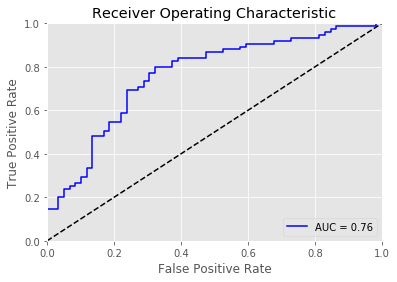

In [50]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_pro)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [51]:
nbroc = roc_auc_score(y_test,y_pred_pro)
nbroc

0.7615819209039547

### random forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
# n_estimators is the no. of the tree
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
# Predicting the Test set results
y_pred = classifier_rf.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[47, 12],
       [23, 52]], dtype=int64)

In [54]:
y_pre_pro = classifier_rf.predict_proba(X_test)[:,1]

In [55]:
rf_accuracy = accuracy_score(y_test,y_pred)
rf_accuracy

0.7388059701492538

In [56]:
rf_logloss = log_loss(y_test,y_pred_pro)
rf_logloss

1.0443532963025095

In [57]:
rf_f1 = f1_score(y_test,y_pred)
rf_f1

0.7482014388489209

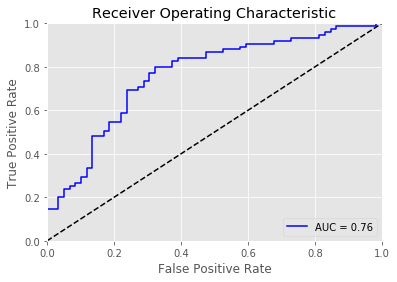

In [58]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_pro)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [59]:
rfroc = roc_auc_score(y_test,y_pred_pro)
rfroc

0.7615819209039547

### xgboost

In [60]:
#fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
# Predicting the Test set results
y_pred = classifier_xgb.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[43, 16],
       [12, 63]], dtype=int64)

In [62]:
y_pred_pro = classifier_xgb.predict_proba(X_test)[:,1]

In [63]:
xgb_accuracy = accuracy_score(y_test,y_pred)
xgb_accuracy

0.7910447761194029

In [64]:
xgb_logloss = log_loss(y_test,y_pred_pro)
xgb_logloss

0.3919636699676847

In [65]:
xgb_f1 = f1_score(y_test,y_pred)
xgb_f1

0.8181818181818181

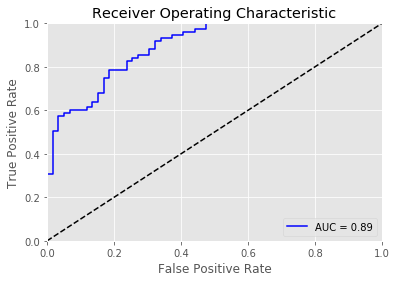

In [66]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_pro)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [67]:
xgbroc = roc_auc_score(y_test,y_pred_pro)
xgbroc

0.8917514124293785

### linear svm

In [68]:
from sklearn.svm import SVC, NuSVC, LinearSVC
classifier_lsvm = LinearSVC()
classifier_lsvm.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [69]:
y_pred = classifier_lsvm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[40, 19],
       [24, 51]], dtype=int64)

In [70]:
svm_accuracy = accuracy_score(y_test,y_pred)
svm_accuracy

0.6791044776119403

In [71]:
svm_logloss = log_loss(y_test,y_pred_pro)
svm_logloss

0.3919636699676847

In [72]:
svm_f1 = f1_score(y_test,y_pred)
svm_f1

0.7034482758620689

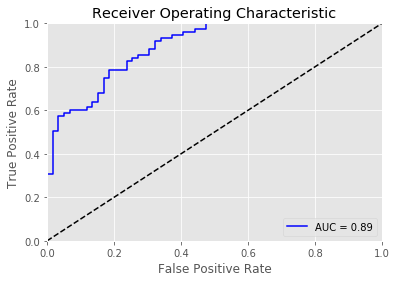

In [73]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_pro)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [74]:
svmroc = roc_auc_score(y_test,y_pred_pro)
svmroc

0.8917514124293785

# logistic regression

In [75]:
classifier_lr =  LogisticRegression()
classifier_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [76]:
y_pred = classifier_lr.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[39, 20],
       [25, 50]], dtype=int64)

In [77]:
lr_accuracy = accuracy_score(y_test,y_pred)
lr_accuracy

0.664179104477612

In [78]:
lr_logloss = log_loss(y_test,y_pred_pro)
lr_logloss

0.3919636699676847

In [79]:
lr_f1 = f1_score(y_test,y_pred)
lr_f1

0.689655172413793

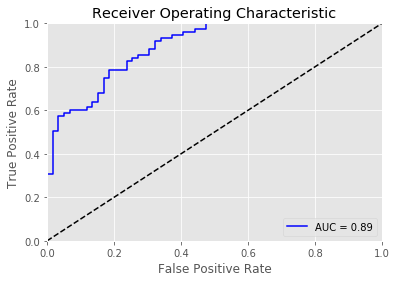

In [80]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_pro)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [81]:
lrroc = roc_auc_score(y_test,y_pred_pro)
lrroc

0.8917514124293785

# real ensenmble

In [82]:
def lr(X_train, y_train, X_test):

    lr =  LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    
    return y_pred

def nb(X_train, y_train, X_test):
    
    nb = GaussianNB()
    nb.fit(X_train,y_train)
    y_pred = nb.predict_proba(X_test)
    
    return y_pred

def rf(X_train, y_train, X_test):
    
    rf =  RandomForestClassifier()
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_test)
    
    return y_pred

def sv(X_train, y_train, X_test):
    
    sv =  SVC(probability = True)
    sv.fit(X_train,y_train)
    y_pred = sv.predict_proba(X_test)
    
    return y_pred

def xgb(X_train, y_train, X_test):
    
    xgb = XGBClassifier()
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict_proba(X_test)
    
    return y_pred

In [83]:
def ensemble(X_train, y_train, X_test):
    lr_y = lr(X_train, y_train, X_test)
    sv_y = sv(X_train, y_train, X_test)
    rf_y = rf(X_train, y_train, X_test)
    nb_y = nb(X_train, y_train, X_test)
    xgb_y = xgb(X_train, y_train, X_test)
    
    final_y = []
    
    for i in range(len(X_test)):
        final_y.append((lr_y[i][1]+ nb_y[i][1]+rf_y[i][1]+ sv_y[i][1]+ xgb_y[i][1])/5)
    return final_y

In [84]:
ensemble_model = ensemble(X_train, y_train, X_test)

In [85]:
ensemble_model

[0.0777079602242761,
 0.30990115252232003,
 0.057300909625407084,
 0.2757501968693937,
 0.5740257630495592,
 0.6396717349155682,
 0.44828513399721814,
 0.029561294791862692,
 0.08931094464924431,
 0.11847999765904578,
 0.06844517356141219,
 0.6151530719660023,
 0.050868659295875474,
 0.2511408353226152,
 0.006368384287249869,
 0.38282600801664957,
 0.38253253825220324,
 0.18120790461339642,
 0.49072706076276795,
 0.36456738766600305,
 0.1207213446196193,
 0.5654088059787107,
 0.7417648238650881,
 0.42096273980963306,
 0.5923767390483994,
 0.6880623400859799,
 0.5742871439835111,
 0.23883313026535102,
 0.3524843143393162,
 0.11742145342407544,
 0.1477014966326167,
 0.36165730168260535,
 0.09509577209829996,
 0.40931900026679074,
 0.40341668016346793,
 0.4961240588095775,
 0.14858886649331646,
 0.07241640814152059,
 0.685680518225183,
 0.06664599531433468,
 0.5168224752364281,
 0.48273422558528833,
 0.17937477592854628,
 0.15479859938632234,
 0.15701674300984295,
 0.2513423541830947,
 0.

In [86]:
log_loss(y_test,ensemble_model)

0.4473042004732165

In [87]:
ebinary = []
for i in ensemble_model:
    if i>0.5:
        ebinary.append(1)
    else:
        ebinary.append(0)

In [88]:
en_accuracy = accuracy_score(y_test,ebinary)
en_accuracy

0.7611940298507462

In [89]:
#cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_lr, X = X_all,
                            y = y_all, cv = 8)

In [90]:
accuracies.mean()

0.7203545548654244

In [91]:
accuracies.std()

0.028362780548410835

In [92]:
en_f1 = f1_score(y_test,ebinary)
en_f1

0.7808219178082192

In [93]:
plt.style.use('ggplot')

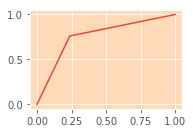

<Figure size 432x288 with 0 Axes>

In [105]:
fpr, tpr, thresholds = roc_curve(y_test,ebinary)
roc_auc = auc(fpr, tpr)
# plot_roc(fpr, tpr, roc_auc)
# plt.show()
fig = plt.figure(1)
axs0 = plt.subplot(221, facecolor = '#FFDAB9')
axs0.plot(fpr, tpr)
plt.show()
plt.savefig("roc ensemble.jpg")

In [ ]:
enroc = roc_auc_score(y_test,ebinary)
enroc

# for 2019 data

In [ ]:
X_train = mm_train[['diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_school_s6','diff_pt_school_ff','diff_pt_career_school_losses','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_adjtempo','diff_adjoe','diff_de','diff_adjde'
]]
y_train = mm_train['team1_win']
X_test = mm_2019[['diff_dist','seed_diff','diff_pt_school_ncaa','diff_pt_school_s6','diff_pt_school_ff','diff_pt_career_school_losses','diff_pt_career_overall_losses','diff_pt_diff_season_wins','diff_pt_diff_season_losses','diff_pt_coach_season_wins','diff_pt_coach_season_losses','diff_fg2pct','diff_fg3pct','diff_ftpct','diff_blockpct','diff_oppfg2pct','diff_oppfg3pct','diff_oppftpct','diff_oppblockpct','diff_f3grate','diff_oppf3grate','diff_arate','diff_opparate','diff_stlrate','diff_oppstlrate','diff_adjtempo','diff_adjoe','diff_de','diff_adjde'
]]

In [ ]:
ensemble_model = ensemble(X_train, y_train, X_test)

In [ ]:
ensemble_model

In [ ]:
len(ensemble_model)

In [ ]:
probability=pd.DataFrame()
newdf = mm_2019[['season','team1_id','team2_id']]
probability['id'] = mm_2019['season'].map(str)+'-'+mm_2019['team1_id'].map(str)+'-'+mm_2019['team2_id'].map(str)
probability['probability'] = pd.DataFrame(ensemble_model)
probability = probability.set_index('id')
probability_sorted = probability.sort_values(by ='id')
probability_sorted.head()

In [ ]:
probability_sorted.to_csv('probability.csv')

# visualization

In [ ]:
name_list = ['lr','nb','svm','rf','xgb']
accuracy_list = [lr_accuracy,nb_accuracy,svm_accuracy,rf_accuracy,xgb_accuracy]
f1_list = [lr_f1,nb_f1,svm_f1,rf_f1,xgb_f1]
roc_list = [lrroc,nbroc,svmroc,rfroc,xgbroc]

In [ ]:
n = 5
fig, ax = plt.subplots()  
index = np.arange(n)
bar_width = 0.35  
opacity = 0.4  
rects1 = plt.bar(index, accuracy_list, bar_width,alpha=opacity, color='b')  
plt.xlabel('model')  
plt.ylabel('Accuracy')  
plt.title('Accuracy by model')  
plt.xticks(index, name_list)
for a,b in zip(index,accuracy_list):
    plt.text(a, b+0.05, '%.3f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("accuracy.jpg")
plt.show()

In [ ]:
n = 5
fig, ax = plt.subplots()  
index = np.arange(n)
bar_width = 0.35  
opacity = 0.4  
rects1 = plt.bar(index, f1_list, bar_width,alpha=opacity, color='b')  
plt.xlabel('model')  
plt.ylabel('F1 Score')  
plt.title('F1 Score by model')  
plt.xticks(index, name_list)
for a,b in zip(index,f1_list):
    plt.text(a, b+0.05, '%.3f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("f1.jpg")
plt.show()

In [ ]:
n = 5
fig, ax = plt.subplots()  
index = np.arange(n)
bar_width = 0.35  
opacity = 0.4  
rects1 = plt.bar(index, roc_list, bar_width,alpha=opacity, color='b')  
plt.xlabel('model')  
plt.ylabel('ROC')  
plt.title('ROC by model')  
plt.xticks(index, name_list)
for a,b in zip(index,roc_list):
    plt.text(a, b+0.05, '%.3f' % b, ha='center', va= 'bottom',fontsize=7)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("roc.jpg")
plt.show()